In [129]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import GradientBoostingClassifier

import xgboost
import optuna

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")


In [48]:
data_transactions = pd.read_json("../transactions.json", lines=True)
data_merchants = pd.read_csv("../merchants.csv")
data_users = pd.read_csv("../users.csv")

In [49]:
location_df = pd.json_normalize(data_transactions['location'])
location_df.columns = ['latitude', 'longitude']

data_transactions = data_transactions.drop(columns=['location']).join(location_df)

In [50]:
df = data_transactions.merge(data_merchants, on='merchant_id', how='left').merge(data_users, on='user_id', how='left')

In [55]:
df["education"] = df["education"].fillna("No Education")  # nan -> wykształcenie niższe niż średnie
df["education"].value_counts()

education
PhD             103760
Master          100526
Bachelor        100325
High School      98823
No Education     96566
Name: count, dtype: int64

In [89]:
df_cleaned = df.drop(columns = ["transaction_id", "currency"])

In [93]:
# Sort by user_id and timestamp for user-based features
df_cleaned = df_cleaned.sort_values(by=["user_id", "timestamp"])
df_cleaned = df_cleaned.reset_index(drop=True) # Ensure unique, sequential index

# User fraud history
df_cleaned['temp_cumulative_fraud'] = df_cleaned.groupby('user_id')['is_fraud'].cumsum()
shifted_cumulative_fraud = df_cleaned.groupby('user_id')['temp_cumulative_fraud'].shift(1)
df_cleaned['user_has_fraud_history'] = shifted_cumulative_fraud.fillna(0).gt(0).astype(int)
df_cleaned = df_cleaned.drop(columns=['temp_cumulative_fraud'])

# User transaction count
df_cleaned["dummy"] = np.ones(len(df_cleaned))
df_cleaned["users_transaction_count"] = df_cleaned.groupby("user_id")["dummy"].cumsum().astype(int)
df_cleaned = df_cleaned.drop(columns=["dummy"])

# Time since last transaction for user
df_cleaned['time_since_last_transaction_user'] = df_cleaned.groupby('user_id')['timestamp'].diff().dt.days
df_cleaned['time_since_last_transaction_user'] = df_cleaned['time_since_last_transaction_user'].fillna(0).astype(int)

# Transaction amount statistics for user
user_amount_mean_shifted = df_cleaned.groupby('user_id')['amount'].transform(lambda x: x.expanding().mean().shift(1))
user_amount_std_shifted = df_cleaned.groupby('user_id')['amount'].transform(lambda x: x.expanding().std().shift(1))
df_cleaned['transaction_amount_std_from_user_mean'] = (df_cleaned['amount'] - user_amount_mean_shifted) / user_amount_std_shifted
df_cleaned['transaction_amount_std_from_user_mean'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_cleaned['transaction_amount_std_from_user_mean'].fillna(0, inplace=True)

# Days since signup
df_cleaned['signup_date'] = pd.to_datetime(df_cleaned['signup_date'])
df_cleaned['transaction_date'] = pd.to_datetime(df_cleaned['timestamp'], unit='ms')
df_cleaned['days_since_signup'] = (df_cleaned['transaction_date'] - df_cleaned['signup_date']).dt.total_seconds() / (24*3600)

# Transaction time features
df_cleaned['transaction_hour'] = df_cleaned['transaction_date'].dt.hour
df_cleaned['is_transaction_night'] = ((df_cleaned['transaction_hour'] >= 0) & (df_cleaned['transaction_hour'] < 6)).astype(int)

# Helper function for rolling count
def rolling_count(series, window):
    # series is a DataFrame with 'transaction_date'
    return series['transaction_date'].apply(
        lambda x: ((series['transaction_date'] >= (x - pd.Timedelta(window))) & (series['transaction_date'] < x)).sum()
    )

# Calculate transactions in the last 1 hour for each user
df_cleaned['transactions_last_1h_user'] = (
    df_cleaned.groupby('user_id', group_keys=False)
    .apply(lambda group: rolling_count(group, '1h'))
    .sort_index()
)

# Calculate transactions in the last 24 hours for each user
df_cleaned['transactions_last_24h_user'] = (
    df_cleaned.groupby('user_id', group_keys=False)
    .apply(lambda group: rolling_count(group, '24h'))
    .sort_index()
)

# Average amount of last 5 transactions for user
df_cleaned['avg_amount_last_5_tx_user'] = df_cleaned.groupby('user_id')['amount'].transform(lambda x: x.rolling(window=5, min_periods=1).mean().shift(1))
df_cleaned['avg_amount_last_5_tx_user'].fillna(0, inplace=True)

# Sort by merchant_id and timestamp for merchant-based features
df_cleaned = df_cleaned.sort_values(by=["merchant_id", "timestamp"])
df_cleaned = df_cleaned.reset_index(drop=True) # Reset index again

# Merchant fraud history
df_cleaned['temp_cumulative_fraud'] = df_cleaned.groupby('merchant_id')['is_fraud'].cumsum()
shifted_cumulative_fraud = df_cleaned.groupby('merchant_id')['temp_cumulative_fraud'].shift(1)
df_cleaned['merchant_has_fraud_history'] = shifted_cumulative_fraud.fillna(0).gt(0).astype(int)
df_cleaned = df_cleaned.drop(columns=['temp_cumulative_fraud'])

df_cleaned = df_cleaned.sort_values(by=["user_id", "timestamp"]) # Consistent sorting
df_cleaned = df_cleaned.reset_index(drop=True) # Clean index

def _get_user_device_mode_for_transform(series):
    # Ensure numpy is imported in your notebook, e.g., import numpy as np
    modes = series.mode()
    if not modes.empty:
        return modes.iloc[0]
    return np.nan

df_cleaned['user_mode_device_temp'] = df_cleaned.groupby('user_id')['device'].transform(_get_user_device_mode_for_transform)
df_cleaned['device_changed'] = 0
has_mode_device = df_cleaned['user_mode_device_temp'].notna()
df_cleaned.loc[has_mode_device, 'device_changed'] = \
    (df_cleaned.loc[has_mode_device, 'device'] != df_cleaned.loc[has_mode_device, 'user_mode_device_temp']).astype(int)

#Change datatypes if necessary
df_cleaned['days_since_signup'] = df_cleaned['days_since_signup'].astype(int)

# Clean up temporary columns
df_features_added = df_cleaned.drop(columns=['transaction_date', 'signup_date'])


In [94]:
# drop the data with time-delta info
df_features_added = df_cleaned.drop(columns=['transaction_date', 'signup_date', 'timestamp'])

In [105]:
from sklearn.preprocessing import OrdinalEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score, confusion_matrix


enc = OrdinalEncoder()

X = df_features_added.drop(columns=["is_fraud"])
y = df_features_added["is_fraud"]

X = pd.DataFrame(enc.fit_transform(X), columns=X.columns)

rus = RandomUnderSampler(random_state=42)

X_res, y_res = rus.fit_resample(X, y)

Tune the model a little bit before RFE

In [119]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "n_jobs": -1,
        "eval_metric": "logloss",
        "use_label_encoder": False,
    }
    model = XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1 = cross_val_score(model, X_res, y_res, cv=cv, scoring="f1").mean()
    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best params:", study.best_params)
print("Best F1:", study.best_value)

[I 2025-05-16 10:52:43,096] A new study created in memory with name: no-name-3abcd5b9-1447-44f4-a491-11468bc7f7be


[I 2025-05-16 10:52:44,252] Trial 0 finished with value: 0.558860328316766 and parameters: {'learning_rate': 0.07227045963478206, 'n_estimators': 62, 'max_depth': 7, 'subsample': 0.6010960394534356, 'colsample_bytree': 0.6988145770996592, 'gamma': 2.177620191620898}. Best is trial 0 with value: 0.558860328316766.
[I 2025-05-16 10:52:47,525] Trial 1 finished with value: 0.5453156212405795 and parameters: {'learning_rate': 0.0685146203478071, 'n_estimators': 120, 'max_depth': 9, 'subsample': 0.7804130776105705, 'colsample_bytree': 0.9853961896454996, 'gamma': 1.9446417926065025}. Best is trial 0 with value: 0.558860328316766.
[I 2025-05-16 10:52:49,892] Trial 2 finished with value: 0.5476989686479482 and parameters: {'learning_rate': 0.09557209285640683, 'n_estimators': 158, 'max_depth': 7, 'subsample': 0.8821037547382217, 'colsample_bytree': 0.7895869032355284, 'gamma': 0.8100014515515974}. Best is trial 0 with value: 0.558860328316766.
[I 2025-05-16 10:52:51,394] Trial 3 finished with 

Best params: {'learning_rate': 0.06225274336620078, 'n_estimators': 234, 'max_depth': 6, 'subsample': 0.9725262870020678, 'colsample_bytree': 0.729999223316507, 'gamma': 4.67092391014463}
Best F1: 0.5749607682269945


In [125]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.base import clone
from xgboost import XGBClassifier

def rfe_with_cv(
    model_prototype,
    X: pd.DataFrame,
    y: pd.Series,
    n_splits: int = 5,
    scoring = make_scorer(f1_score),
    random_state = 42)
    
    # Initialization
    features = X.columns.tolist()
    best_score = -np.inf
    best_features = features.copy()
    f1_history = {}

    # CV strategy
    cv = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    # Iterative elimination
    while features:
        # Evaluate current feature set via cross-validation
        model = clone(model_prototype)
        scores = cross_val_score(
            model,
            X[features],
            y,
            cv=cv,
            scoring=scoring,
            n_jobs=-1
        )
        mean_score = np.mean(scores)
        f1_history[len(features)] = mean_score

        # Update best if improved (or same score with fewer features)
        if mean_score > best_score or (
            np.isclose(mean_score, best_score) and len(features) < len(best_features)
        ):
            best_score = mean_score
            best_features = features.copy()

        # Stop if only one feature remains
        if len(features) == 1:
            break

        # Fit on the full data to get importances
        model_full = clone(model_prototype)
        model_full.fit(X[features], y)
        importances = pd.Series(
            model_full.feature_importances_,
            index=features
        )
        # Eliminate least important feature
        least_imp = importances.idxmin()
        features.remove(least_imp)

    print(
        f"RFE done: best F1={best_score:.4f} with {len(best_features)} features."
    )
    return best_features, f1_history


best_params = {'learning_rate': 0.06225274336620078, 'n_estimators': 234, 'max_depth': 6, 'subsample': 0.9725262870020678, 'colsample_bytree': 0.729999223316507, 'gamma': 4.67092391014463}

xgb_prototype = XGBClassifier(**best_params)
best_feats, history = rfe_with_cv(xgb_prototype, X_res, y_res)

RFE done: best F1=0.5803 with 3 features.


Now with reduce feature size lets run Optuna with Stratified KFold again to tune the final model

In [132]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Use only the RFE-selected features
X_rfe = X_res[best_feats]

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "n_jobs": -1,
        "eval_metric": "logloss",
        "use_label_encoder": False,
    }
    model = XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1 = cross_val_score(model, X_rfe, y_res, cv=cv, scoring="f1").mean()
    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=60)

print("Best params:", study.best_params)
print("Best F1:", study.best_value)

[I 2025-05-16 11:15:58,589] A new study created in memory with name: no-name-5428b7fc-0085-4859-b08f-3d79d41bfbfc
[I 2025-05-16 11:15:59,832] Trial 0 finished with value: 0.5660964267408339 and parameters: {'learning_rate': 0.26543829344784864, 'n_estimators': 51, 'max_depth': 7, 'subsample': 0.7540771246706623, 'colsample_bytree': 0.6942341244688814, 'gamma': 0.21464636716703733}. Best is trial 0 with value: 0.5660964267408339.
[I 2025-05-16 11:16:00,865] Trial 1 finished with value: 0.5630070580831936 and parameters: {'learning_rate': 0.27749505594991913, 'n_estimators': 82, 'max_depth': 8, 'subsample': 0.6690453682061623, 'colsample_bytree': 0.6220747726601121, 'gamma': 3.2451311943346846}. Best is trial 0 with value: 0.5660964267408339.
[I 2025-05-16 11:16:02,550] Trial 2 finished with value: 0.5686258958921353 and parameters: {'learning_rate': 0.03412470973210163, 'n_estimators': 84, 'max_depth': 7, 'subsample': 0.7019462210654983, 'colsample_bytree': 0.7824627593606372, 'gamma': 

Best params: {'learning_rate': 0.0783977100006569, 'n_estimators': 144, 'max_depth': 2, 'subsample': 0.9968671932668101, 'colsample_bytree': 0.7824185455643041, 'gamma': 1.7869281747876058}
Best F1: 0.5808732252825461


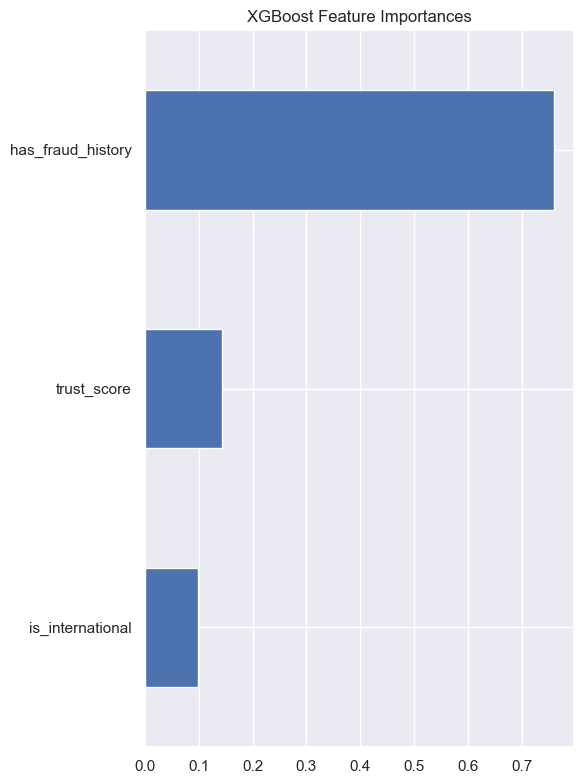

In [135]:
final_model = XGBClassifier(**study.best_params)
final_model.fit(X_res[best_feats], y_res)

importances = pd.Series(final_model.feature_importances_, index=best_feats)
importances.sort_values().plot(kind='barh', figsize=(6,8))
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()